Dataset folder: /content/dataset/ProcessedDataSet
Example files: ['7', '6', '3', '4', '2', '1', '9', '8', '0', '5']
Classes: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
Total images: 50
Using device: cpu
Epoch 1/8 - Train Loss: 2.5549, Val Loss: 2.3895
Epoch 2/8 - Train Loss: 2.3155, Val Loss: 2.4008
Epoch 3/8 - Train Loss: 2.2084, Val Loss: 2.5699
Epoch 4/8 - Train Loss: 2.1509, Val Loss: 2.8893
Epoch 5/8 - Train Loss: 1.8470, Val Loss: 3.2552
Epoch 6/8 - Train Loss: 1.4687, Val Loss: 4.5722
Epoch 7/8 - Train Loss: 0.9947, Val Loss: 4.9261
Epoch 8/8 - Train Loss: 0.6124, Val Loss: 6.5220


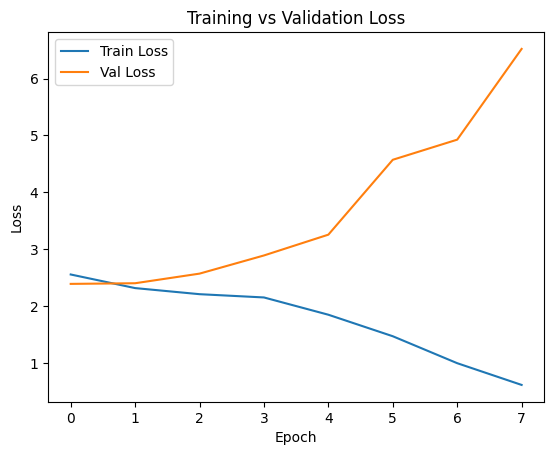

Model saved to: /content/puzzarm_model.pth


In [25]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

data_dir = "/content/dataset/ProcessedDataSet"
print("Dataset folder:", data_dir)
print("Example files:", os.listdir(data_dir)[:10])

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

full_dataset = datasets.ImageFolder(data_dir, transform=transform)

train_size = int(0.7 * len(full_dataset))
val_size   = int(0.2 * len(full_dataset))
test_size  = len(full_dataset) - train_size - val_size

train_set, val_set, test_set = torch.utils.data.random_split(
    full_dataset, [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

train_loader = DataLoader(train_set, batch_size=4, shuffle=True)
val_loader   = DataLoader(val_set, batch_size=4, shuffle=False)
test_loader  = DataLoader(test_set, batch_size=4, shuffle=False)

class_names = full_dataset.classes
print("Classes:", class_names)
print("Total images:", len(full_dataset))

class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 32 * 32, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = SimpleCNN(num_classes=len(class_names)).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 8
train_losses = []
val_losses   = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_losses.append(val_loss / len(val_loader))

    print(f"Epoch {epoch+1}/{epochs} - "
          f"Train Loss: {train_losses[-1]:.4f}, "
          f"Val Loss: {val_losses[-1]:.4f}")

plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

save_path = "/content/puzzarm_model.pth"
torch.save(model.state_dict(), save_path)
print("Model saved to:", save_path)


In [26]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 32 * 32, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x


In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = SimpleCNN(num_classes=len(class_names)).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 8
train_losses = []
val_losses   = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_train_loss = running_loss / len(train_loader)
    train_losses.append(epoch_train_loss)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    epoch_val_loss = val_loss / len(val_loader)
    val_losses.append(epoch_val_loss)

    print(f"Epoch {epoch+1}/{epochs} - "
          f"Train Loss: {epoch_train_loss:.4f}, "
          f"Val Loss: {epoch_val_loss:.4f}")


Using device: cpu
Epoch 1/8 - Train Loss: 2.4568, Val Loss: 2.3310
Epoch 2/8 - Train Loss: 2.2931, Val Loss: 2.3177
Epoch 3/8 - Train Loss: 2.2487, Val Loss: 2.4694
Epoch 4/8 - Train Loss: 2.1164, Val Loss: 3.0789
Epoch 5/8 - Train Loss: 1.8082, Val Loss: 4.2955
Epoch 6/8 - Train Loss: 1.2821, Val Loss: 5.1541
Epoch 7/8 - Train Loss: 0.8651, Val Loss: 7.2265
Epoch 8/8 - Train Loss: 0.4186, Val Loss: 8.9523


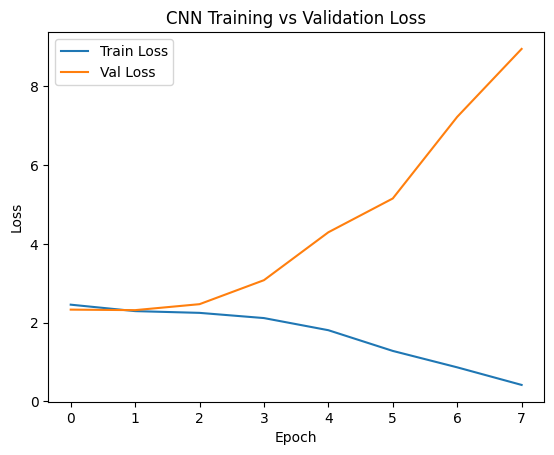

In [28]:
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("CNN Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [29]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

test_acc = correct / total if total > 0 else 0.0
print(f"CNN Test Accuracy: {test_acc:.3f}")

save_path = "/content/puzzarm_cnn_model.pth"
torch.save(model.state_dict(), save_path)
print("CNN model saved to:", save_path)


CNN Test Accuracy: 0.000
CNN model saved to: /content/puzzarm_cnn_model.pth


In [30]:
model.eval()
print("Number of batches in test_loader:", len(test_loader))

for batch_idx, (images, labels) in enumerate(test_loader):
    images, labels = images.to(device), labels.to(device)

    outputs = model(images)
    _, preds = torch.max(outputs, 1)

    print(f"Batch {batch_idx}")
    print("True labels:", labels.cpu().numpy())
    print("Pred labels:", preds.cpu().numpy())


Number of batches in test_loader: 2
Batch 0
True labels: [4 9 5 8]
Pred labels: [1 8 7 5]
Batch 1
True labels: [1]
Pred labels: [3]


In [31]:
from torchvision import models
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np


In [33]:
num_classes = len(class_names)

mobilenet = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)

in_features = mobilenet.classifier[1].in_features
mobilenet.classifier[1] = nn.Linear(in_features, num_classes)

mobilenet = mobilenet.to(device)

criterion_m = nn.CrossEntropyLoss()
optimizer_m = optim.Adam(mobilenet.parameters(), lr=1e-4)

epochs_m = 8
train_losses_m = []
val_losses_m   = []

for epoch in range(epochs_m):
    mobilenet.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer_m.zero_grad()
        outputs = mobilenet(images)
        loss = criterion_m(outputs, labels)
        loss.backward()
        optimizer_m.step()

        running_loss += loss.item()

    train_losses_m.append(running_loss / len(train_loader))

    mobilenet.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = mobilenet(images)
            loss = criterion_m(outputs, labels)
            val_loss += loss.item()

    val_losses_m.append(val_loss / len(val_loader))

    print(f"[MobileNet] Epoch {epoch+1}/{epochs_m} - "
          f"Train Loss: {train_losses_m[-1]:.4f}, "
          f"Val Loss: {val_losses_m[-1]:.4f}")



[MobileNet] Epoch 1/8 - Train Loss: 2.3631, Val Loss: 2.3404
[MobileNet] Epoch 2/8 - Train Loss: 2.1883, Val Loss: 2.2721
[MobileNet] Epoch 3/8 - Train Loss: 2.1212, Val Loss: 2.2783
[MobileNet] Epoch 4/8 - Train Loss: 2.0386, Val Loss: 2.3193
[MobileNet] Epoch 5/8 - Train Loss: 1.9688, Val Loss: 2.3078
[MobileNet] Epoch 6/8 - Train Loss: 1.8530, Val Loss: 2.3568
[MobileNet] Epoch 7/8 - Train Loss: 1.7582, Val Loss: 2.3001
[MobileNet] Epoch 8/8 - Train Loss: 1.6411, Val Loss: 2.2804


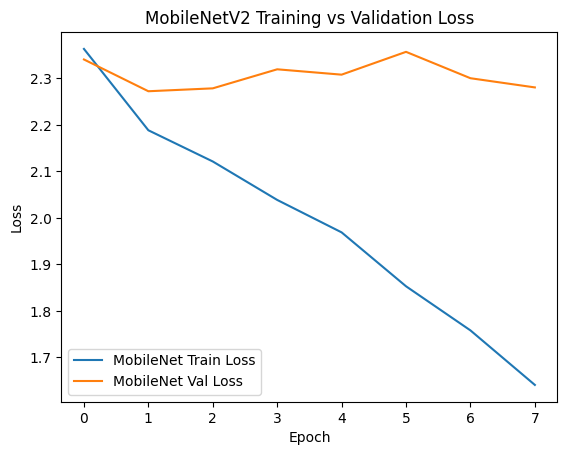

In [34]:
plt.plot(train_losses_m, label="MobileNet Train Loss")
plt.plot(val_losses_m, label="MobileNet Val Loss")
plt.title("MobileNetV2 Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [39]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

def evaluate_model(model, loader, class_names, device):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)

    acc = (all_labels == all_preds).mean()

    label_indices = list(range(len(class_names)))

    print("Accuracy:", acc)
    print(classification_report(
        all_labels,
        all_preds,
        labels=label_indices,
        target_names=class_names,
        digits=3,
        zero_division=0
    ))

    cm = confusion_matrix(all_labels, all_preds, labels=label_indices)
    return acc, cm


In [40]:
print("=== CNN on test set ===")
acc_cnn, cm_cnn = evaluate_model(model, test_loader, class_names, device)

print("\n=== MobileNetV2 on test set ===")
acc_mnet, cm_mnet = evaluate_model(mobilenet, test_loader, class_names, device)

print("\nCNN test accuracy:", acc_cnn)
print("MobileNetV2 test accuracy:", acc_mnet)


=== CNN on test set ===
Accuracy: 0.0
              precision    recall  f1-score   support

           0      0.000     0.000     0.000       0.0
           1      0.000     0.000     0.000       1.0
           2      0.000     0.000     0.000       0.0
           3      0.000     0.000     0.000       0.0
           4      0.000     0.000     0.000       1.0
           5      0.000     0.000     0.000       1.0
           6      0.000     0.000     0.000       0.0
           7      0.000     0.000     0.000       0.0
           8      0.000     0.000     0.000       1.0
           9      0.000     0.000     0.000       1.0

    accuracy                          0.000       5.0
   macro avg      0.000     0.000     0.000       5.0
weighted avg      0.000     0.000     0.000       5.0


=== MobileNetV2 on test set ===
Accuracy: 0.4
              precision    recall  f1-score   support

           0      0.000     0.000     0.000         0
           1      0.000     0.000     0.000    

In [41]:
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, class_names, title, filename=None):
    fig, ax = plt.subplots(figsize=(4,4))
    im = ax.imshow(cm, cmap="Blues")

    ax.set_xticks(range(len(class_names)))
    ax.set_xticklabels(class_names)
    ax.set_yticks(range(len(class_names)))
    ax.set_yticklabels(class_names)

    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_title(title)

    for i in range(len(class_names)):
        for j in range(len(class_names)):
            ax.text(j, i, cm[i, j],
                    ha="center", va="center", color="black", fontsize=8)

    plt.tight_layout()
    if filename is not None:
        plt.savefig(filename, dpi=150)
    plt.show()


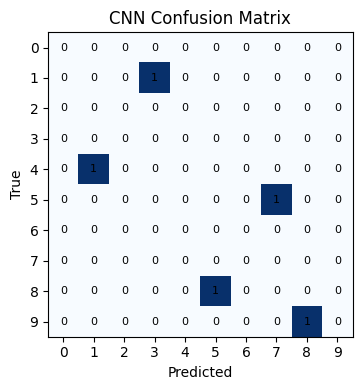

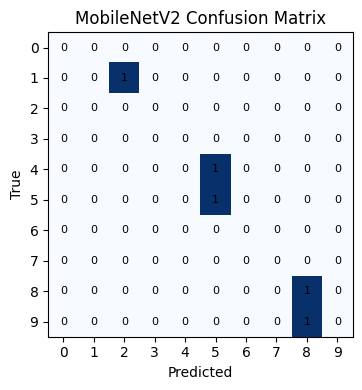

In [42]:
plot_confusion_matrix(cm_cnn,  class_names,
                      "CNN Confusion Matrix",
                      filename="cnn_confusion_matrix.png")

plot_confusion_matrix(cm_mnet, class_names,
                      "MobileNetV2 Confusion Matrix",
                      filename="mobilenet_confusion_matrix.png")


In [47]:
import glob
from PIL import Image
from torchvision import transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

num_classes = len(class_names)

deploy_model = models.mobilenet_v2(weights=None)
in_features = deploy_model.classifier[1].in_features
deploy_model.classifier[1] = nn.Linear(in_features, num_classes)

state_dict = torch.load("/content/puzzarm_mobilenet_v2.pth",
                        map_location=device)
deploy_model.load_state_dict(state_dict)
deploy_model = deploy_model.to(device)
deploy_model.eval()

inference_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])


Using device: cpu


In [48]:
def predict_image(img_path, model):
    image = Image.open(img_path).convert("RGB")
    tensor = inference_transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(tensor)
        probs = torch.softmax(outputs, dim=1)
        conf, pred_idx = torch.max(probs, 1)

    predicted_class = class_names[pred_idx.item()]
    confidence = conf.item()
    all_probs = probs.cpu().numpy()[0]

    return image, predicted_class, confidence, all_probs


Found 5 inference images


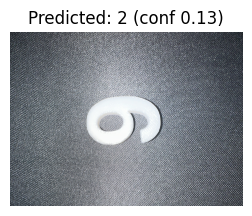

Image: IMG_2884.jpeg
Predicted class: 2
Probabilities: {'0': 0.1228666752576828, '1': 0.0899733304977417, '2': 0.1268002837896347, '3': 0.10335350036621094, '4': 0.07245387136936188, '5': 0.1065547838807106, '6': 0.11584813892841339, '7': 0.09487683326005936, '8': 0.0863228440284729, '9': 0.08094972372055054}
----------------------------------------


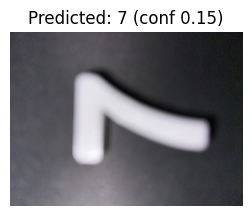

Image: IMG_2885.jpeg
Predicted class: 7
Probabilities: {'0': 0.10802280157804489, '1': 0.07108300179243088, '2': 0.09794498980045319, '3': 0.10811634361743927, '4': 0.08703053742647171, '5': 0.09812304377555847, '6': 0.10725127160549164, '7': 0.14611582458019257, '8': 0.09089690446853638, '9': 0.08541521430015564}
----------------------------------------


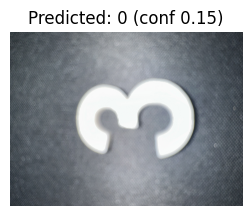

Image: IMG_2886.jpeg
Predicted class: 0
Probabilities: {'0': 0.15262970328330994, '1': 0.09803996980190277, '2': 0.0902329757809639, '3': 0.11807595193386078, '4': 0.04793926700949669, '5': 0.08323666453361511, '6': 0.10799574106931686, '7': 0.11885660886764526, '8': 0.10873420536518097, '9': 0.07425893843173981}
----------------------------------------


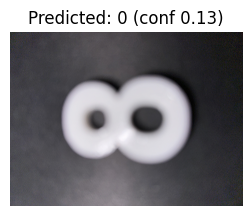

Image: IMG_2887.jpeg
Predicted class: 0
Probabilities: {'0': 0.13108886778354645, '1': 0.06602856516838074, '2': 0.09483113139867783, '3': 0.10543631762266159, '4': 0.08311668038368225, '5': 0.08365172892808914, '6': 0.10783108323812485, '7': 0.13021036982536316, '8': 0.10729003697633743, '9': 0.09051517397165298}
----------------------------------------


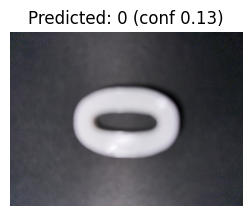

Image: IMG_2888.jpeg
Predicted class: 0
Probabilities: {'0': 0.1320805847644806, '1': 0.07261508703231812, '2': 0.09846363961696625, '3': 0.09967188537120819, '4': 0.0805528461933136, '5': 0.09018690139055252, '6': 0.10190767794847488, '7': 0.1285327672958374, '8': 0.09882553666830063, '9': 0.09716305881738663}
----------------------------------------


In [53]:
inference_dir = "/content/inference_samples"
image_paths = sorted(glob.glob(inference_dir + "/*.jpeg"))

print("Found", len(image_paths), "inference images")

for img_path in image_paths:
    img, pred_class, conf, all_probs = predict_image(img_path, deploy_model)

    plt.figure(figsize=(3,3))
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Predicted: {pred_class} (conf {conf:.2f})")
    plt.show()

    print("Image:", os.path.basename(img_path))
    print("Predicted class:", pred_class)
    print("Probabilities:", {c: float(p) for c, p in zip(class_names, all_probs)})
    print("-" * 40)
